# U-NET example

Example of U-NET module using tensorflow 2. The example uses the unet packages cloned from https://github.com/jakeret/unet

In [1]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import unet
from unet import utils
from unet.datasets import circles

import inspect

print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.3.0
GPU is NOT AVAILABLE


## Auxiliary functions

In [2]:
def read_data(fname):
    with np.load(fname, allow_pickle=False) as npz_file:
        # Load the arrays
        X = npz_file['features']
        y = npz_file['targets']
    return X, y

In [3]:
def data_generator(file_list, stop_at_end=False):
    i = 0
    while True:
        if i >= len(file_list):
            if stop_at_end:
                break
            i = 0
            np.random.shuffle(file_list)            
        else:
            X, y = read_data(file_list[i])            
            yield X, y
            i = i + 1

In [4]:
def get_dataset(flist, stop_at_end=False):
    X, y = read_data(flist[0])
    nx = X.shape[0]
    ny = X.shape[1]
    nchannels = X.shape[2]
    nclasses = y.shape[2]
    return tf.data.Dataset.from_generator(
        data_generator, args=[flist, stop_at_end], output_types=(tf.float32, tf.float32),
        output_shapes = ((nx, ny, nchannels), (nx, ny, nclasses)))

In [5]:
def get_dataset2(flist):
    X, y = read_data(flist[0])
    nx = X.shape[0]
    ny = X.shape[1]
    nchannels = X.shape[2]
    nclasses = y.shape[2]
    nimages = len(flist)    
    X = np.empty((nimages, nx, ny, nchannels), dtype=np.float32)
    y = np.empty((nimages, nx, ny, nclasses), dtype=np.float32)
                 
    for i, fname in enumerate(flist):
        X[i, :, :, :], y[i, :, :, :] = read_data(fname)
    return X, y

## Load data

In [6]:
flist = glob.glob('/data/ml_course/05_Capstone_project/dl_data/*_data.npz')
flist.sort()
np.random.shuffle(flist)
print('Number of input files:', len(flist))

Number of input files: 4351


In [7]:
nfiles_te = 4
nfiles_va = 4
nfiles_tr = 36

flist_te = flist[0:nfiles_te]
flist_va = flist[nfiles_te:nfiles_te+nfiles_va]
flist_tr = flist[nfiles_te+nfiles_va:nfiles_te+nfiles_va+nfiles_tr]

print('Number of test files:', len(flist_te))
print('Number of validation files:', len(flist_va))
print('Number of training files:', len(flist_tr))

Number of test files: 4
Number of validation files: 4
Number of training files: 36


In [8]:
train_dataset = get_dataset(flist_tr, stop_at_end=False)
validation_dataset = get_dataset(flist_va, stop_at_end=False)
test_dataset = get_dataset(flist_te, stop_at_end=True)

## Create model

In [9]:
unet_model = unet.build_model(channels=3,
                              num_classes=2,
                              layer_depth=3,
                              filters_root=16)
unet.finalize_model(unet_model)

## Train model

In [10]:
epochs = 3
batch_size = 4
fit_kwargs = {
    'steps_per_epoch': int(nfiles_tr/batch_size),
    'validation_steps': int(nfiles_va/batch_size)}

trainer = unet.Trainer(checkpoint_callback=False)
history = trainer.fit(unet_model,
            train_dataset,
            validation_dataset,
            epochs=epochs,
            batch_size=batch_size,
            **fit_kwargs)

Epoch 1/3
1/9 [==>...........................] - ETA: 0s - loss: 0.6020 - categorical_crossentropy: 0.6020 - categorical_accuracy: 0.8921 - mean_iou: 0.2758 - dice_coefficient: 0.5506 - auc: 0.9254WARNING:tensorflow:From /opt/anaconda3/envs/exts-ml2/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
9/9 [==============================] - 21s 2s/step - loss: 0.2570 - categorical_crossentropy: 0.2570 - categorical_accuracy: 0.9669 - mean_iou: 0.4046 - dice_coefficient: 0.8086 - auc: 0.9890 - val_loss: 0.0409 - val_categorical_crossentropy: 0.0409 - val_categorical_accuracy: 0.9966 - val_mean_iou: 0.4979 - val_dice_coefficient: 0.9958 - val_auc: 0.9966 - learning_rate: 0.0010
Epoch 2/3
9/9 [==============================] - 20s 2s/step - loss: 0.0225 - categorical_crossentropy: 0.0225 - categorical_a

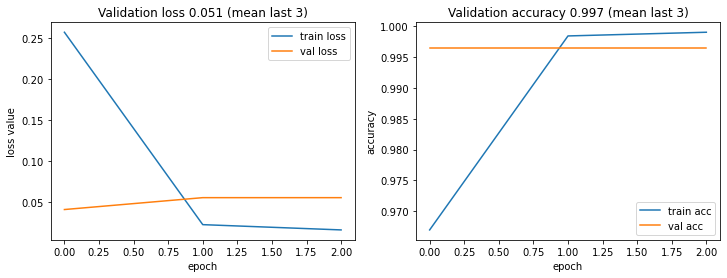

In [11]:
# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot accuracy values
ax1.plot(history.history['loss'], label='train loss')
ax1.plot(history.history['val_loss'], label='val loss')
ax1.set_title('Validation loss {:.3f} (mean last 3)'.format(
    np.mean(history.history['val_loss'][-3:]) # last three values
))
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss value')
ax1.legend()

# Plot accuracy values
ax2.plot(history.history['categorical_accuracy'], label='train acc')
ax2.plot(history.history['val_categorical_accuracy'], label='val acc')
ax2.set_title('Validation accuracy {:.3f} (mean last 3)'.format(
    np.mean(history.history['val_categorical_accuracy'][-3:]) # last three values
))
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()
plt.show()

## Make predictions

In [12]:
pred_batch_size = 4
prediction = unet_model.predict(test_dataset.batch(pred_batch_size), verbose=1, steps=int(nfiles_te/pred_batch_size))

1/1 [==============================] - 0s 1ms/step


In [13]:
trainer.evaluate(unet_model, test_dataset, shape=prediction.shape[1:])

4/4 [==============================] - 1s 216ms/step - loss: 0.0160 - categorical_crossentropy: 0.0160 - categorical_accuracy: 0.9990 - mean_iou: nan - dice_coefficient: 0.9990 - auc: 0.9990


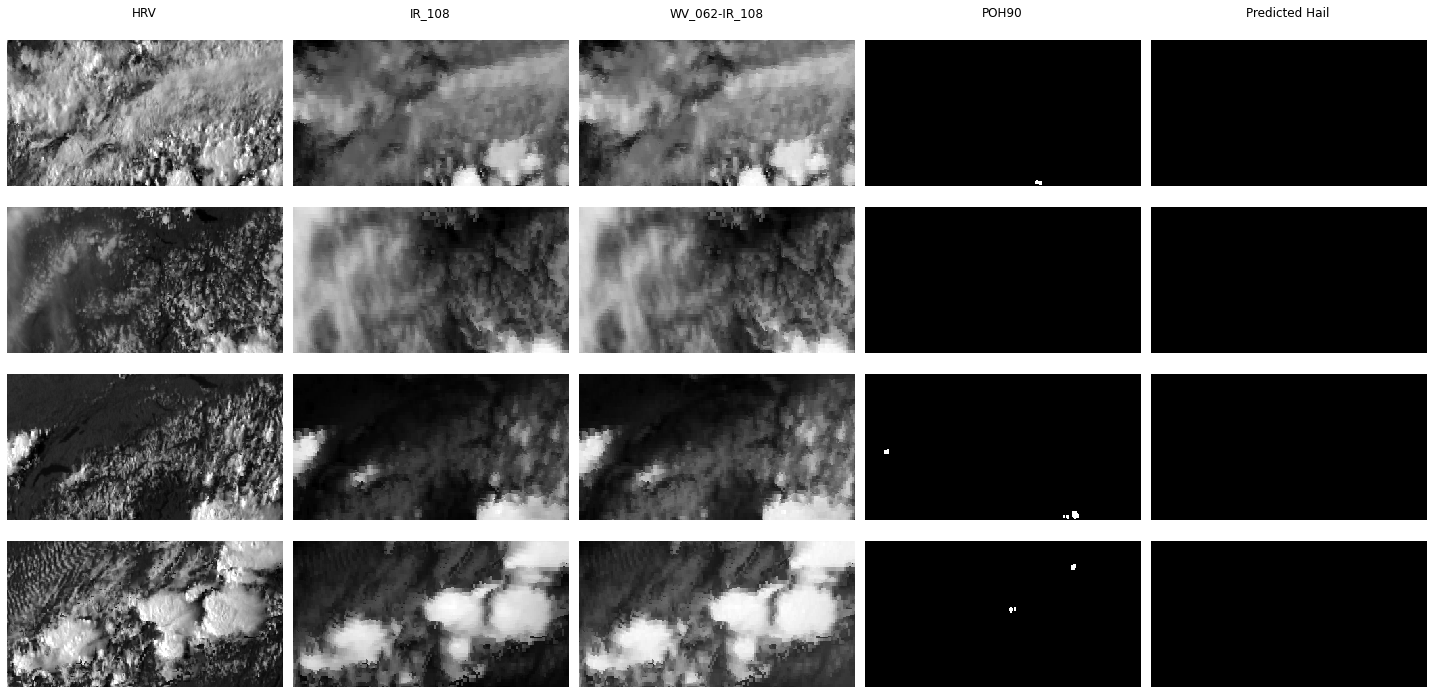

In [14]:
fig, ax = plt.subplots(4, 5, figsize=(20,10))
dataset = test_dataset.map(utils.crop_image_and_label_to_shape(prediction.shape[1:]))

for i, (image, label) in enumerate(dataset.take(4)):
    hrv = image.numpy()[:, :, 0]
    ir = image.numpy()[:, :, 1]
    diff = image.numpy()[:, :, 2]
    
    lab = np.argmax(label, axis=-1)
    pred = np.argmax(prediction[i,...], axis=-1)
    
    
    ax[i][0].matshow(hrv.T[::-1, :], cmap=plt.cm.gray)
    ax[i][0].axis('off')
    ax[0][0].set_title('HRV')
    
    ax[i][1].matshow(ir.T[::-1, :], cmap=plt.cm.gray_r)
    ax[i][1].axis('off')
    ax[0][1].set_title('IR_108')
    
    ax[i][2].matshow(diff.T[::-1, :], cmap=plt.cm.gray)
    ax[i][2].axis('off')
    ax[0][2].set_title('WV_062-IR_108')
    
    ax[i][3].matshow(lab.T[::-1, :], cmap=plt.cm.gray)
    ax[i][3].axis('off')
    ax[0][3].set_title('POH90')
    
    ax[i][4].matshow(pred.T[::-1, :], cmap=plt.cm.gray)
    ax[i][4].axis('off')
    ax[0][4].set_title('Predicted Hail')
    
plt.tight_layout()